<a href="https://colab.research.google.com/github/L120Git/NLP_Google_Restaurants/blob/main/3_NLP_modelado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##0.Librerías necesarias

In [5]:
#!pip install rarfile
#!pip install unzip
!pip install stop-words
!pip install num2words


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [89]:
#Librerias necesarias
import numpy as np
import pandas as pd
from google.colab import drive
import random
#import rarfile # para descomprimir archivos
import json
#import csv 
#para limpiar los datos
import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
nltk.download('omw-1.4')
import string
import unicodedata
from num2words import num2words
#para reducir la dimensión
from sklearn.manifold import TSNE
#para representar
import matplotlib.pyplot as plt

#análisis exloratorio
from collections import Counter
from nltk import ngrams
from nltk.probability import FreqDist
from wordcloud import WordCloud

#preprocesado
from stop_words import get_stop_words
import unicodedata
import re
from sklearn.utils import shuffle

#modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import os
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow
from tensorflow import keras
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from sklearn.svm import SVC
from keras.layers import Embedding, LSTM, Dense, Dropout, GRUV2, SimpleRNN
#reporte
from sklearn.metrics import classification_report, accuracy_score, roc_curve, precision_recall_curve


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


##1. Carga de datos

In [8]:
# Montamos GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#cargamos los datos necesarios desde nuestro google drive
path = '/content/drive/MyDrive/NLP/'

train_clean = pd.read_csv(f'{path}train_clean.csv')
test_clean= pd.read_csv(f'{path}test_clean.csv')

In [10]:
train_clean

,review_clean,sentiment_label
0,want great slice new york pizza come burke str...,0
1,way much breading shrimp also really loud next...,1
2,wa first time eaten peruvian food wa flavorful,0
3,ihop ha better food go south time get ham chee...,1
4,bowling giant jenga corn hole ping pong tried ...,1
...,...,...
4760,opinion frosted hawaiian tasted like blend ice...,1
4761,chicken sandwich double berger combo,1
4762,came try something new breakfast disappointed way,0
4763,daughter blackened fish sandwich wife shrimp d...,1


In [11]:
test_clean

,review_clean,sentiment_label
0,wife really enjoy pasta fresh salad updated re...,1
1,pork cracklins boudin ball sweet potato beignet,0
2,salad appetizer main course came time,1
3,burger great fry good like onion ring better,1
4,always bomb place never disappoints best fast ...,0
...,...,...
1584,burger though wa average something could get n...,1
1585,good flavor personally prefer thicker noodle a...,1
1586,worth one time stop youre fan irish coffee,1
1587,wasnt fond root beer doughnut sweet dough seem...,1


##2. Split de los datos

In [12]:
#dividimos con las columnas 'processedReview' y las etiquetas 'sentiment_label'

#split conjunto de train
X_train = train_clean['review_clean']
y_train = train_clean['sentiment_label']

#split conjunto de test
X_test = test_clean['review_clean']
y_test = test_clean['sentiment_label']


In [13]:
X_train.iloc[:10]

0    want great slice new york pizza come burke str...
1    way much breading shrimp also really loud next...
2       wa first time eaten peruvian food wa flavorful
3    ihop ha better food go south time get ham chee...
4    bowling giant jenga corn hole ping pong tried ...
5    excellent eel shashime chewy octapus leathery ...
6    passing chicago really nice evening sat outsid...
7    go old fashioned vanilla birthday cake homer h...
8                 2 margarita combo plate salad 70 tip
9                       well back try rice noodle dish
Name: review_clean, dtype: object

In [14]:
y_train.iloc[:10]

0    0
1    1
2    0
3    1
4    1
5    1
6    0
7    0
8    0
9    1
Name: sentiment_label, dtype: int64

##3. Extracción de características

In [15]:
# CountVectorizer
cv = CountVectorizer(ngram_range=(1, 2), max_features=1000, max_df=0.95, min_df=5)
X_train_cv = cv.fit_transform(train_clean['review_clean']).toarray() #.toarray() para plotearlo
X_test_cv = cv.transform(test_clean['review_clean']).toarray()

# TfIdfVectorizer 
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000, max_df=0.95, min_df=5)
X_train_tfidf = tfidf.fit_transform(train_clean['review_clean'])
X_test_tfidf = tfidf.transform(test_clean['review_clean'])

In [16]:
print(list(tfidf.vocabulary_.items())[:20])

[('want', 960), ('great', 408), ('slice', 789), ('new', 575), ('york', 995), ('pizza', 656), ('come', 200), ('street', 833), ('cheap', 144), ('got', 403), ('taste', 851), ('perfection', 638), ('try', 896), ('cheeseburger', 151), ('hot', 440), ('wing', 979), ('new york', 576), ('way', 965), ('much', 562), ('breading', 103)]


In [17]:
print(len(tfidf.vocabulary_))

1000


##3.1 Frecuencia de las palabras

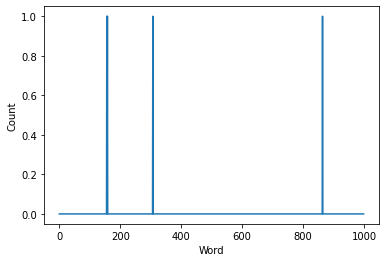

In [18]:
#Frecuencia de las palabras
plt.plot(X_train_cv[5,:]) #CountVectorized train en array
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

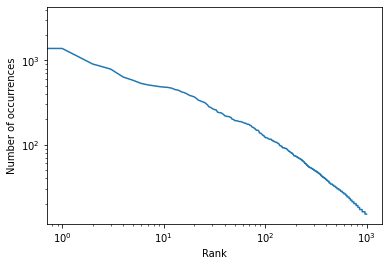

In [19]:

#Observamos la ley de Zipf
word_freq = X_train_cv.sum(axis=0)

sorted_word_freq = np.sort(word_freq)[::-1]

plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

###3.2 Score IDF de algunas palabras

In [20]:
words_example = [
    'sauce',
    'very',
    'good',
    'amazing',
    'great',
    'fresh',
    'fish',
    'deviled',
    'but',
    'was',
    'never',
    'not',
    'wasn´t'
]

In [21]:
vocab_idf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
sauce               3.640
very                OOV                 
good                2.432
amazing             3.909
great               3.229
fresh               3.786
fish                4.085
deviled             6.636
but                 OOV                 
was                 OOV                 
never               5.518
not                 OOV                 
wasn´t              OOV                 


###3.3 Palabras con el TF-IDF en alguna review

In [22]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 192
Sentiment: 1
Review: seafood fresh tasty


In [23]:
doc_vector = X_train_tfidf[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=tfidf.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 192:
            tfidf
seafood  0.622755
tasty    0.569485
fresh    0.536528

Top 10 words with lowest TF_IDF in the review 192:
            tfidf
seafood  0.622755
tasty    0.569485
fresh    0.536528


###3.4 Chi2(χ²) scores

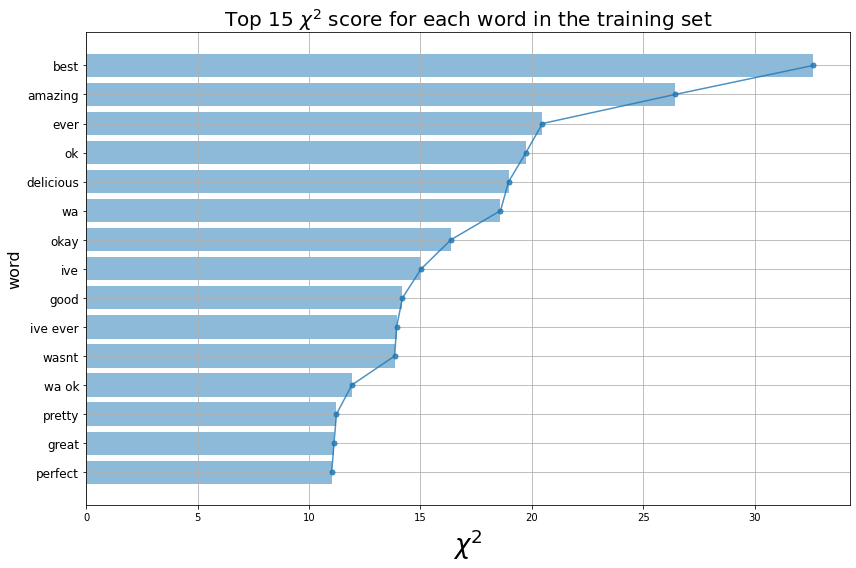

In [24]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_tfidf, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

## 4. Entrenamiento modelo de clasificación binaria 

In [25]:
#Regresión logística
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000] #lista de parámetros

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=1000)
    lr.fit(X_train_tfidf, y_train)
    
    train_predict = lr.predict(X_train_tfidf)
    test_predict = lr.predict(X_test_tfidf) ####
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.5645059786028949
Accuracy for C=0.05: 0.6463184392699811
Accuracy for C=0.25: 0.7161736941472624
Accuracy for C=0.5: 0.7293895531780994
Accuracy for C=1: 0.7325361862806796
Accuracy for C=10: 0.7331655129011957
Accuracy for C=100: 0.7168030207677785
Accuracy for C=1000: 0.7061044682190056
Accuracy for C=10000: 0.7061044682190056


In [26]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[449 243]
 [224 673]]

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       692
           1       0.73      0.75      0.74       897

    accuracy                           0.71      1589
   macro avg       0.70      0.70      0.70      1589
weighted avg       0.71      0.71      0.71      1589

Accuracy score:0.7061044682190056


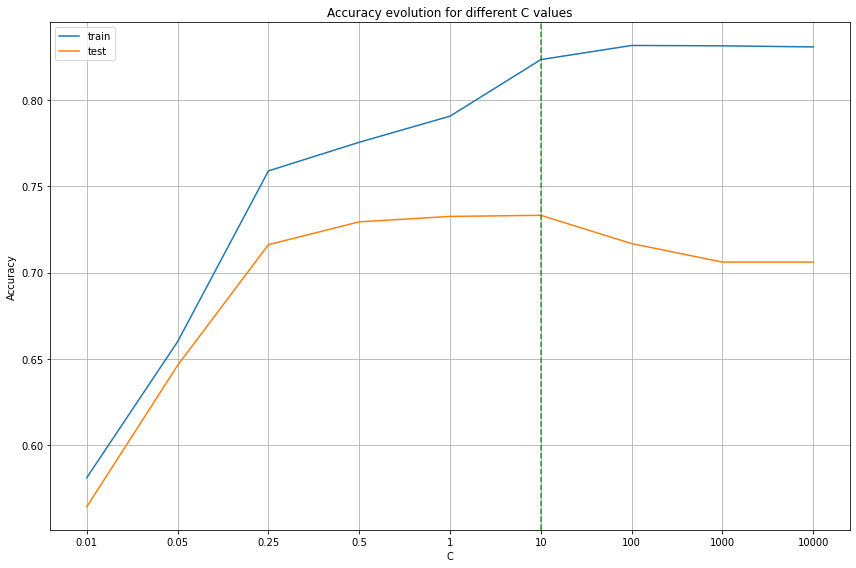

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [28]:
p, r, thresholds = precision_recall_curve(y_test, test_predict)

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

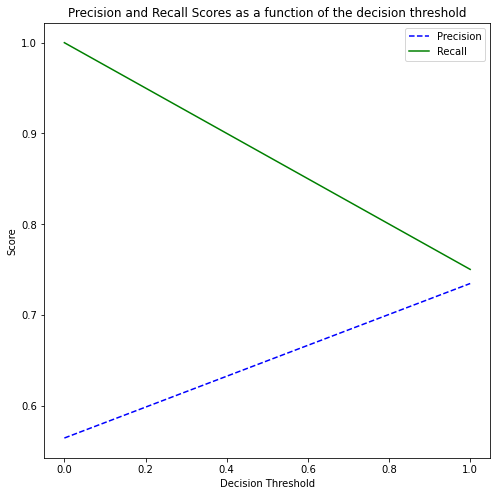

In [30]:
plot_precision_recall_vs_threshold(p, r, thresholds)

### 4.1 Predicción

In [31]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(test_clean.iloc[review_index]['sentiment_label']))
    r = test_clean.iloc[review_index]['review_clean']
    print('Prediction: {}'.format(lr.predict(tfidf.transform([r]))))

In [32]:
for i in random.sample(range(0, len(test_clean)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 420
Actual sentiment: 0
Prediction: [1]

Review no. 110
Actual sentiment: 0
Prediction: [1]

Review no. 704
Actual sentiment: 1
Prediction: [1]

Review no. 744
Actual sentiment: 1
Prediction: [1]

Review no. 1368
Actual sentiment: 0
Prediction: [0]


## 5. Entrenamiento de un modelo con árboles de predicción

In [51]:


#Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
        'n_estimators': [16, 32, 64],
        'learning_rate': [0.1, 0.5, 1.0],
        'max_depth': [1, 2, 3]
}
    
def classify_gboost(X_train, X_test, y_train, y_test):  
    #creo el clasificador      
    clf = GradientBoostingClassifier(random_state=42) #n_estimators=n_estimators, learning_rate=1.0,  max_depth=1

    #meto una grid_search para buscar los mejores parámetros de entrenamiento
    grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    clf.fit(X_train, y_train)
    
    #guardo los mejores parámetros
    best_params = grid_search.best_params_

    #le paso al clasificador los best_params
    clf2 = GradientBoostingClassifier(**best_params, random_state=42)
    clf2.fit(X_train_tfidf, y_train)

    #predict
    test_predict= clf2.predict(X_test_tfidf)

    print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
    print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
    print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, test_predict)))
    
    return clf2


clf2 = classify_gboost(X_train_tfidf, X_test_tfidf, y_train, y_test)

Confusion matrix:
[[329 363]
 [121 776]]

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       692
           1       0.68      0.87      0.76       897

    accuracy                           0.70      1589
   macro avg       0.71      0.67      0.67      1589
weighted avg       0.70      0.70      0.68      1589

Accuracy score: 0.6954


##6. Modelado CNN

### 6.1 Preparación de los datos 

In [75]:
#####################################################################
#DEBEMOS IMPORTAR ESTO DEL DRIVE QUE YA ESTÁ HECHO
# Mezclamos los datos con sus etiquetas
x_train, y_train =shuffle(train_clean['review_clean'],train_clean['sentiment_label'])
x_test,y_test =shuffle(test_clean['review_clean'],test_clean['sentiment_label'])

print(y_train.tail(20))

3188    0
4472    0
4647    1
1707    1
3747    1
40      0
3292    1
1292    1
1788    1
4439    0
4680    1
4423    1
4159    1
2416    1
4701    1
585     0
2694    0
69      1
1961    1
806     1
Name: sentiment_label, dtype: int64


In [76]:
# Media de palabras en la reviews.
# RRN necesitamos establcer el tamaño de neruonas 
# primero hacer el análisis para ver el número medio y máximo de palabras en las reviews.
#si una frase se queda corta, la palabrs restantes se rellenaran de 0. Esto sería negativop
max = 0
mean = []
for example in x_train:
  length = len(example)
  mean.append(len(example))
  if length > max:
    max = length

In [77]:
sum(mean) / len(mean)

98.3286463798531

In [78]:
max

2491

In [86]:
#preparamos X_train y X_test para la CNN
mx_w = max #número máx de palabras 
tokenizer = Tokenizer(num_words= mx_w)

x_train_tkns = tokenizer.texts_to_sequences(x_train) #tokenizamos cada frase en una secuencia numérica
x_test_tkns = tokenizer.texts_to_sequences(x_test)


In [87]:
max_words = 500 #escogemos una muestra del max de palabras del conjunto de entrenamiento
#hacemos el padding
X_train = pad_sequences(x_train_tkns, maxlen=max_words)
X_test = pad_sequences(x_test_tkns, maxlen=max_words)

In [120]:
# Vectorizador, extractor de características
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=500, ## max_words?
    strip_accents='ascii',
    ngram_range=(1, 1)
)

X_train_ = cv.fit_transform(x_train)
X_test_ = cv.transform(x_test)

###6.2 Creación del modelo

In [121]:
embedding_size = 32
vocabulary_size= 138683 #total_words (train, con el que entrenamos)
#modelo
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 32)           4437856   
                                                                 
 lstm_2 (LSTM)               (None, 100)               53200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 4,491,157
Trainable params: 4,491,157
Non-trainable params: 0
_________________________________________________________________
None


In [122]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [124]:
X_train_ = X_train_.toarray()
X_test_ = X_test_.toarray()

In [125]:
batch_size = 64
num_epochs = 1

model.fit(X_train_, y_train, #con el vector de caracteristicas
          validation_split=0.2,
          batch_size=batch_size, epochs=num_epochs)

60/60 [==============================] - 84s 1s/step - loss: 0.6812 - accuracy: 0.5834 - val_loss: 0.6825 - val_accuracy: 0.5729


In [126]:
scores = model.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.5645059943199158


#HASTA AQUÍ TODO BIEN

In [ ]:
model_file = "lstm_model.h5"  # HDF5 file
model.save(os.path.join(model_file))

Vamos a ver con GRU:

In [ ]:
embedding_size = 32
model_gru = Sequential()
model_gru.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model_gru.add(GRUV2(100))
model_gru.add(Dense(1, activation='sigmoid'))

print(model_gru.summary())

In [ ]:
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 64
num_epochs = 1

X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]  # rest for training

model_gru.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

In [ ]:
model_file = "gru_model.h5"  # HDF5 file
model_gru.save(os.path.join(cache_dir, model_file))

In [ ]:
scores = model_gru.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Y por último con RNN:

In [ ]:
embedding_size = 32
model_rnn = Sequential()
model_rnn.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model_rnn.add(SimpleRNN(100))
model_rnn.add(Dense(1, activation='sigmoid'))

print(model_rnn.summary())

In [ ]:
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 64
num_epochs = 1

X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]  # rest for training

model_rnn.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

In [ ]:
model_file = "rnn_model.h5"  # HDF5 file
model_rnn.save(os.path.join(cache_dir, model_file))

In [ ]:
scores = model_rnn.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Y si quitamos el Embedding?

# 5. RNN + word2vec Embedding